# Batchnormalization Layer

> [reference] https://github.com/hunkim/DeepLearningZeroToAll/blob/master/lab-10-6-mnist_nn_batchnorm.ipynb

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
%matplotlib inline

In [5]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
mnist.train.images.shape

(55000, 784)

In [11]:
class Model:
    def __init__(self, name, input_dim, output_dim, hidden_dims=[32, 32], 
                 use_batchnorm=True, activation_fn=tf.nn.relu, optimizer=tf.train.AdamOptimizer, lr=0.01):
    
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, [None, input_dim], name='X')
            self.y = tf.placeholder(tf.float32, [None, output_dim], name='y')
            self.mode = tf.placeholder(tf.bool, name='train_mode')

            net = self.X

            for i, h_dim in enumerate(hidden_dims):
                with tf.variable_scope('layer{}'.format(i)):
                    net = tf.layers.dense(net, h_dim)

                    if use_batchnorm:
                        net = tf.layers.batch_normalization(net, training=self.mode)

                    net = activation_fn(net)

            net = tf.contrib.layers.flatten(net)
            net = tf.layers.dense(net, output_dim)

            self.loss = tf.nn.softmax_cross_entropy_with_logits(logits=net, labels=self.y)
            self.loss = tf.reduce_mean(self.loss, name='loss')

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=name)

            with tf.control_dependencies(update_ops):
                self.train_op = optimizer(lr).minimize(self.loss)

            softmax = tf.nn.softmax(net, name='softmax')
            self.accuracy = tf.equal(tf.argmax(softmax, 1), tf.argmax(self.y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.accuracy, tf.float32))

In [12]:
class Solver:
    def __init__(self, sess, model):
        self.model = model
        self.sess = sess
        
    def train(self, X, y):
        feed = {
            self.model.X: X,
            self.model.y: y,
            self.model.mode: True
        }
        train_op = self.model.train_op
        loss = self.model.loss
        
        return self.sess.run([train_op, loss], feed_dict=feed)
    
    def evaluate(self, X, y, batch_size=None):
        if batch_size:
            N = X.shape[0]
            
            total_loss = 0
            total_acc = 0
            
            for i in range(0, N, batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                
                feed = {
                    self.model.X: X_batch,
                    self.model.y: y_batch,
                    self.model.mode: False
                }
                
                loss = self.model.loss
                accuracy = self.model.accuracy
                
                step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed)
                
                total_loss += step_loss * X_batch.shape[0]
                total_acc += step_acc * X_batch.shape[0]
                
            total_loss /= N
            total_acc /= N
            
            return total_loss, total_acc
        
        else:
            feed = {
                self.model.X: X,
                self.model.y: y,
                self.model.mode: True
            }
            
            loss = self.model.loss
            accuracy = self.model.accuracy
            
            return self.sess.run([loss, accuracy], feed_dict=feed)

In [13]:
input_dim = 784
output_dim = 10
N = 55000

tf.reset_default_graph()
sess = tf.InteractiveSession()

bn = Model('batchnorm', input_dim, output_dim, use_batchnorm=True)
nn = Model('no_norm', input_dim, output_dim, use_batchnorm=False)

bn_solver = Solver(sess, bn)
nn_solver = Solver(sess, nn)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [14]:
epoch_n = 10
batch_size = 32

train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

In [15]:
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(epoch_n):
    for _ in range(N//batch_size):
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        
        _, bn_loss = bn_solver.train(X_batch, y_batch)
        _, nn_loss = nn_solver.train(X_batch, y_batch)
        
    b_loss, b_acc = bn_solver.evaluate(mnist.train.images, mnist.train.labels, batch_size)
    n_loss, n_acc = nn_solver.evaluate(mnist.train.images, mnist.train.labels, batch_size)
    
    train_losses.append([b_loss, n_loss])
    train_accs.append([b_acc, n_acc])
    
    print(f'[Epoch {epoch}-TRAIN] Batchnorm Loss(Acc): {b_loss:.5f}({b_acc:.2%}) vs\
    No Batchnorm Loss(Acc): {n_loss:.5f}({n_acc:.2%})')
    
    b_loss, b_acc = bn_solver.evaluate(mnist.validation.images, mnist.validation.labels)
    n_loss, n_acc = nn_solver.evaluate(mnist.validation.images, mnist.validation.labels)
    
    valid_losses.append([b_loss, n_loss])
    valid_accs.append([b_acc, n_acc])
    
    print(f'[Epoch {epoch}-VALID] Batchnorm Loss(Acc): {b_loss:.5f}({b_acc:.2%}) vs\
    No Batchnorm Loss(Acc): {n_loss:.5f}({n_acc:.2%})')
    print()

[Epoch 0-TRAIN] Batchnorm Loss(Acc): 0.14148(95.67%) vs    No Batchnorm Loss(Acc): 0.23513(93.10%)
[Epoch 0-VALID] Batchnorm Loss(Acc): 0.14037(95.70%) vs    No Batchnorm Loss(Acc): 0.23918(93.20%)

[Epoch 1-TRAIN] Batchnorm Loss(Acc): 0.11060(96.49%) vs    No Batchnorm Loss(Acc): 0.18313(94.84%)
[Epoch 1-VALID] Batchnorm Loss(Acc): 0.12181(96.24%) vs    No Batchnorm Loss(Acc): 0.19735(94.48%)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): 0.09409(97.01%) vs    No Batchnorm Loss(Acc): 0.17063(95.05%)
[Epoch 2-VALID] Batchnorm Loss(Acc): 0.11111(96.72%) vs    No Batchnorm Loss(Acc): 0.19592(94.58%)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): 0.08972(97.19%) vs    No Batchnorm Loss(Acc): 0.19336(94.83%)
[Epoch 3-VALID] Batchnorm Loss(Acc): 0.09991(96.90%) vs    No Batchnorm Loss(Acc): 0.20635(94.88%)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): 0.06808(97.87%) vs    No Batchnorm Loss(Acc): 0.12722(96.24%)
[Epoch 4-VALID] Batchnorm Loss(Acc): 0.09512(97.26%) vs    No Batchnorm Loss(Acc): 0.15899(95.56%)

[Epoc

In [16]:
bn_solver.evaluate(mnist.test.images, mnist.test.labels)

[0.08465369, 0.975]

In [17]:
nn_solver.evaluate(mnist.test.images, mnist.test.labels)

[0.20858417, 0.9534]

In [19]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]
    
    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    
    if ylim:
        plt.ylim(ylim)
        
    if title:
        plt.title(title)
        
    plt.legend()
    plt.grid('on')
    plt.show()

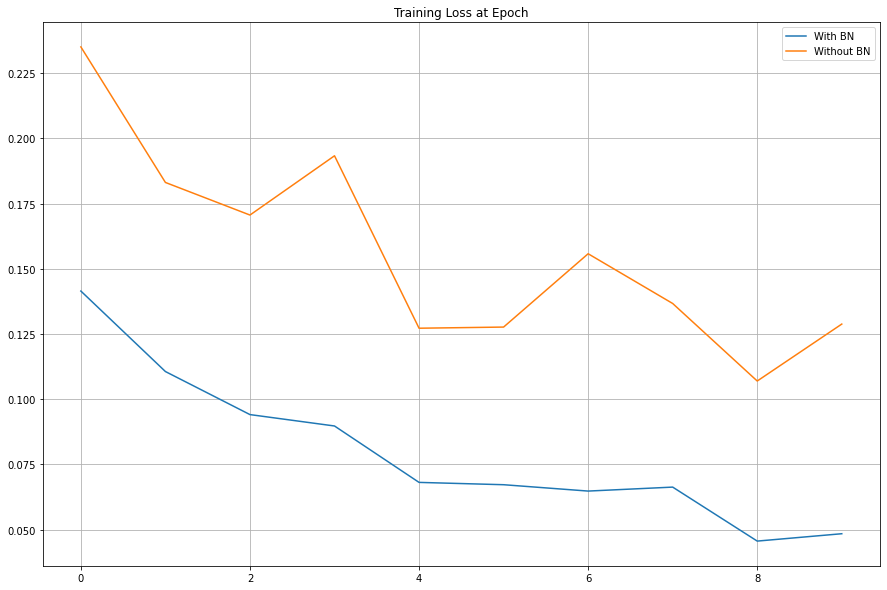

In [20]:
plot_compare(train_losses, title='Training Loss at Epoch')

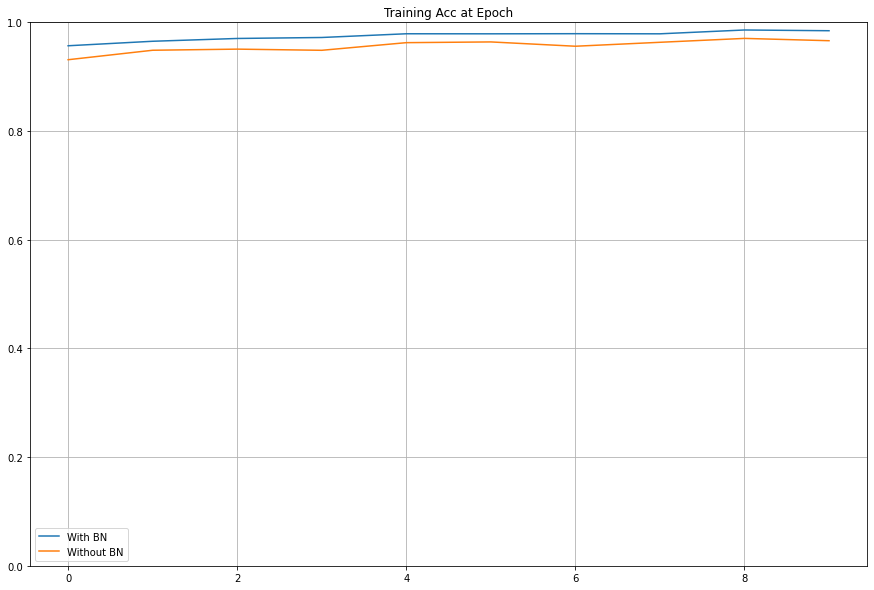

In [22]:
plot_compare(train_accs, [0, 1.0], title="Training Acc at Epoch")

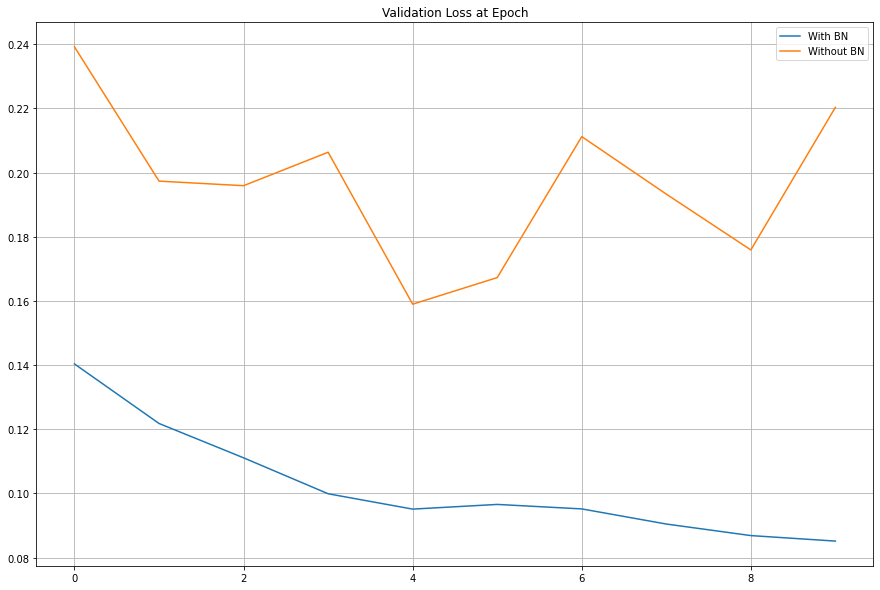

In [23]:
plot_compare(valid_losses, title='Validation Loss at Epoch')

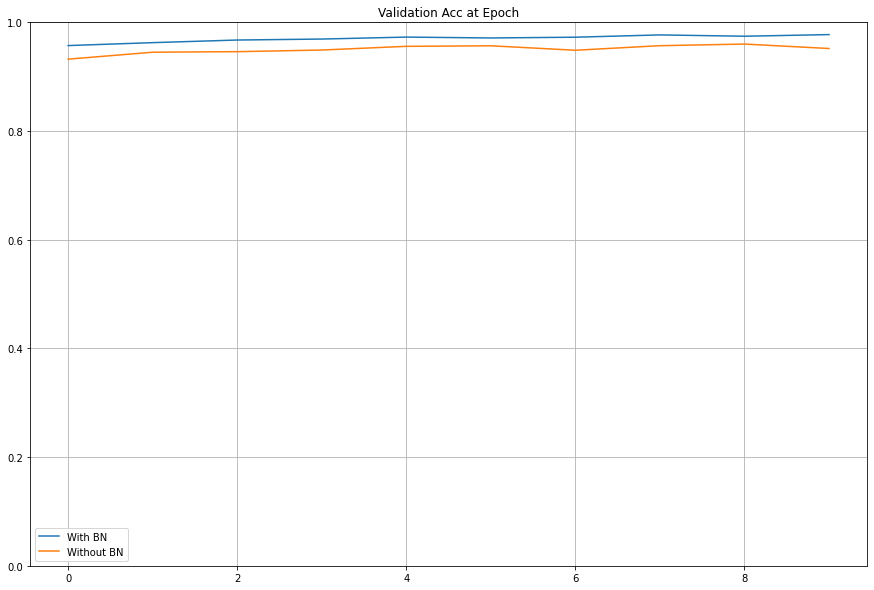

In [24]:
plot_compare(valid_accs, [0, 1.], title='Validation Acc at Epoch')